In [2]:
%load_ext autoreload
%autoreload 2
import dpp
import numpy as np
import torch
from copy import deepcopy
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dpp.data.list_datasets()

['final_batched_high_load_n_400/20210610_23:14_fanout_large_fetched_397_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01',
 'final_batched_high_load_n_400/20210611_00:04_parallel_large_fetched_390_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01',
 'final_batched_high_load_n_400/20210611_00:53_tree_large_fetched_399_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01',
 'final_batched_high_load_n_400/20210611_01:43_fanout_large_fetched_391_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand',
 'final_batched_high_load_n_400/20210611_02:33_parallel_large_fetched_383_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand',
 'final_batched_high_load_n_400/20210611_03:23_tree_large_fetched_398_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand',
 'final_batched_high_load_n_400/20210611_04:13_fanout_small_fetched_384_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.0001_u2_0.0001',
 'final_batched_high_load_n_400/20210611_07:23_fanout_small_fetched_394_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.0001_u2_0.0001_rand',
 'final_batched_high_load_n_400/20210611_11:

In [8]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
dataset_name = 'final_low_load_n_1000/20210605_02:08_sequence_fetched_1000_n1_1000_l1_0.3_u1_0.6'  # run dpp.data.list_datasets() to see the list of available datasets

# Model config
context_size = 64                 # Size of the RNN hidden vector
mark_embedding_size = 32          # Size of the mark embedding (used as RNN input)
num_mix_components = 64           # Number of components for a mixture model
rnn_type = "GRU"                  # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
coldstart_feature = True          # Enabling the cold start feature

# Training config
batch_size = 64        # Number of sequences in a batch
regularization = 1e-5  # L2 regularization parameter
learning_rate = 1e-3   # Learning rate for Adam optimizer
max_epochs = 200       # For how many epochs to train
display_step = 5       # Display training statistics after every display_step
patience = 20          # After how many consecutive epochs without improvement of val loss to stop training

In [9]:
# Load the data
dataset = dpp.data.load_dataset(dataset_name)
d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

dl_train = d_train.get_dataloader(batch_size=batch_size, shuffle=True)
dl_val = d_val.get_dataloader(batch_size=batch_size, shuffle=False)
dl_test = d_test.get_dataloader(batch_size=batch_size, shuffle=False)

In [10]:
# Define the model
print('Building model...')
mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

model = dpp.models.LogNormMix(
    num_marks=d_train.num_marks,
    mean_log_inter_time=mean_log_inter_time,
    std_log_inter_time=std_log_inter_time,
    context_size=context_size,
    mark_embedding_size=mark_embedding_size,
    rnn_type=rnn_type,
    num_mix_components=num_mix_components,
    coldstart_feature=coldstart_feature
)
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

Building model...


In [11]:
def aggregate_loss_over_dataloader(dl):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_loss += -model.log_prob(batch).sum().item()
            total_count += batch.size
    return total_loss / total_count

def aggregate_mae_over_dataloader(dl):
    total_mae = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            predicted_inter_times, _ = model.predict(batch)
            abs_errors = torch.abs(predicted_inter_times - batch.inter_times) * batch.mask
            total_mae += abs_errors.sum()
            total_count += batch.mask.sum()
    return total_mae / total_count

def aggregate_accuracy_over_dataloader(dl):
    total_correct_preds = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:            
            _, predicted_marks = model.predict(batch)
            correct_predictions = (predicted_marks == batch.marks) * batch.mask
            total_correct_preds += correct_predictions.sum().item()
            total_count += batch.mask.sum().item()
    return total_correct_preds / total_count

def errors_over_dataloader(dl):
    result = torch.Tensor()
    with torch.no_grad():
        for batch in dl:
            predicted_inter_times, _ = model.predict(batch)
            errors = predicted_inter_times - batch.inter_times
            indices = torch.nonzero(batch.mask, as_tuple=True)
            filtered_errors = errors[indices]
            result = torch.cat((result, filtered_errors), dim=-1)
    return result

In [12]:
# Traning
print('Starting training...')

impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []

for epoch in range(max_epochs):
    model.train()
    for batch in dl_train:
        opt.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        loss_val = aggregate_loss_over_dataloader(dl_val)
        training_val_losses.append(loss_val)
        mae_val = aggregate_mae_over_dataloader(dl_val)
        acc_val = aggregate_accuracy_over_dataloader(dl_val)
        
    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if epoch % display_step == 0:        
        print(f"Epoch {epoch:4d}: loss_train_last_batch = {loss.item():.1f}, loss_val = {loss_val:.1f}, mae_val = {mae_val:.1f}, acc_val = {acc_val:.1f}")

Starting training...
Epoch    0: loss_train_last_batch = 89.5, loss_val = 89.0, mae_val = 385.9, acc_val = 0.5
Epoch    5: loss_train_last_batch = 47.2, loss_val = 47.2, mae_val = 385.9, acc_val = 1.0
Epoch   10: loss_train_last_batch = 42.8, loss_val = 41.1, mae_val = 385.9, acc_val = 1.0
Epoch   15: loss_train_last_batch = 37.7, loss_val = 39.5, mae_val = 385.9, acc_val = 1.0
Epoch   20: loss_train_last_batch = 35.9, loss_val = 36.7, mae_val = 385.9, acc_val = 1.0
Epoch   25: loss_train_last_batch = 32.8, loss_val = 32.1, mae_val = 385.9, acc_val = 1.0
Epoch   30: loss_train_last_batch = 31.5, loss_val = 32.1, mae_val = 385.9, acc_val = 1.0
Epoch   35: loss_train_last_batch = 35.2, loss_val = 38.7, mae_val = 385.9, acc_val = 1.0
Epoch   40: loss_train_last_batch = 26.5, loss_val = 25.9, mae_val = 385.9, acc_val = 1.0
Epoch   45: loss_train_last_batch = 36.3, loss_val = 40.5, mae_val = 385.9, acc_val = 1.0
Epoch   50: loss_train_last_batch = 32.6, loss_val = 30.1, mae_val = 385.9, acc

In [ ]:
# Evaluation via negative log-likelihood
model.load_state_dict(best_model)
model.eval()

# All training & testing sequences stacked into a single batch
with torch.no_grad():
    final_loss_train = aggregate_loss_over_dataloader(dl_train)
    final_loss_val = aggregate_loss_over_dataloader(dl_val)
    final_loss_test = aggregate_loss_over_dataloader(dl_test)

print(f'Negative log-likelihood:\n'
      f' - Train: {final_loss_train:.1f}\n'
      f' - Val:   {final_loss_val:.1f}\n'
      f' - Test:  {final_loss_test:.1f}')    

In [ ]:
# Evaluation via mean absolute error
model.load_state_dict(best_model)
model.eval()

with torch.no_grad():
    final_mae_train = aggregate_mae_over_dataloader(dl_train)
    final_mae_val = aggregate_mae_over_dataloader(dl_val)
    final_mae_test = aggregate_mae_over_dataloader(dl_test)

print(f'Mean absolute error:\n'
      f' - Train: {final_mae_train:.1f}\n'
      f' - Val:   {final_mae_val:.1f}\n'
      f' - Test:  {final_mae_test:.1f}')

Text(0.5, 1.0, 'Differences between Predicted and True Inter-Time')

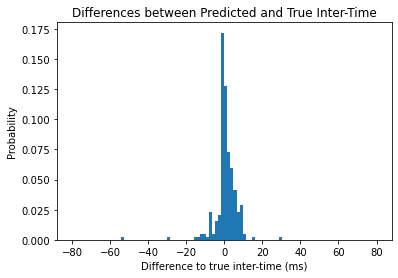

In [388]:
# Evaluation of differences between predicted and true inter-time
model.load_state_dict(best_model)
model.eval() 

plt.hist(errors_over_dataloader(dl_test).numpy(), bins=100, label="test", range=(-80, 80), density=True)
plt.ylabel("Probability")
plt.xlabel("Difference to true inter-time (ms)")
plt.title("Differences between Predicted and True Inter-Time")

In [ ]:
# Evaluation via accuracy
model.load_state_dict(best_model)
model.eval()

with torch.no_grad():
    final_acc_train = aggregate_accuracy_over_dataloader(dl_train)
    final_acc_val = aggregate_accuracy_over_dataloader(dl_val)
    final_acc_test = aggregate_accuracy_over_dataloader(dl_test)

print(f'Accuracy:\n'
      f' - Train: {final_acc_train:.1f}\n'
      f' - Val:   {final_acc_val:.1f}\n'
      f' - Test:  {final_acc_test:.1f}')

Compare the distribution of sequence lengths for real and simulated data

In [ ]:
sampled_batch = model.sample(t_max=100, batch_size=1000)

In [ ]:
real_batch = dpp.data.Batch.from_list([s for s in dataset])

In [ ]:
plt.hist(sampled_batch.mask.sum(-1).cpu().numpy(), 50, label="Sampled", density=True, range=(0, 300));
plt.hist(real_batch.mask.sum(-1).cpu().numpy(), 50, alpha=0.3, label="Real data", density=True, range=(0, 300));
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.legend()